# Portfolio Construction with GNN
***
*Ivan Jordanov*

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from time import time
import finnhub
import networkx as nx
from datetime import datetime
import math
from sklearn.feature_selection import mutual_info_regression as mi_reg

In [2]:
df = pd.read_csv('s&p500.csv')

In [3]:
df.head()

,Unnamed: 0,Datetime,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,0,2012-01-03,83.49,10.3175,27.1390,35.00,18.25,52.95,12.200,28.89,...,102.78120,185.59,111.2888,27.34,25.14,42.1150,35.72,52.3284,16.765,31.01
1,1,2012-01-04,84.18,10.4825,27.0337,35.32,18.11,52.93,12.105,29.37,...,102.19842,187.87,109.3749,27.16,25.97,42.4026,35.45,51.6202,17.140,31.02
2,2,2012-01-05,83.80,10.5025,26.9715,33.36,18.27,51.92,12.110,29.24,...,103.97325,190.20,108.2325,27.28,25.60,42.7262,35.40,52.2314,17.620,31.04
3,3,2012-01-06,83.37,10.4350,26.7275,33.80,18.14,51.83,12.240,29.07,...,103.09908,190.34,104.4242,27.20,25.17,43.0354,35.11,52.3672,17.640,31.03
4,4,2012-01-09,83.87,10.4925,26.7227,33.00,18.21,51.74,12.200,28.91,...,102.22491,191.13,104.1313,27.22,25.27,42.8700,34.95,52.7553,17.880,32.00


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
final = df.set_index('Datetime')

In [6]:
neg = final.copy(deep=True)

In [7]:
def remove_coins_with_negative_return(df):
    returns = df.iloc[-1].values - df.iloc[0].values
    for (index, colname) in enumerate(df):
        if returns[index] < 0:
            df=df.drop(colname, axis=1)
            
    return df

In [8]:
neg = remove_coins_with_negative_return(neg)

In [9]:
neg.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,GWW,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-03,83.49,10.3175,27.1390,35.00,18.25,52.95,12.200,28.89,28.57,47.7760,...,26.82,102.78120,185.59,27.34,25.14,42.1150,35.72,52.3284,16.765,31.01
2012-01-04,84.18,10.4825,27.0337,35.32,18.11,52.93,12.105,29.37,28.28,47.7190,...,26.98,102.19842,187.87,27.16,25.97,42.4026,35.45,51.6202,17.140,31.02
2012-01-05,83.80,10.5025,26.9715,33.36,18.27,51.92,12.110,29.24,28.48,48.0743,...,27.55,103.97325,190.20,27.28,25.60,42.7262,35.40,52.2314,17.620,31.04
2012-01-06,83.37,10.4350,26.7275,33.80,18.14,51.83,12.240,29.07,28.72,48.1445,...,27.39,103.09908,190.34,27.20,25.17,43.0354,35.11,52.3672,17.640,31.03
2012-01-09,83.87,10.4925,26.7227,33.00,18.21,51.74,12.200,28.91,28.53,47.9602,...,27.78,102.22491,191.13,27.22,25.27,42.8700,34.95,52.7553,17.880,32.00


In [10]:
returns = np.log(neg.iloc[-1].values) - np.log(neg.iloc[0].values)

In [11]:
returns = np.nan_to_num(returns)

In [12]:
log_returns1 = np.log(neg - np.log(neg.shift()))

In [13]:
log_returns1.fillna(0, inplace=True)

In [14]:
corr = log_returns1.corr('spearman')

In [15]:
corr.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,GWW,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,1.000000,0.792196,0.561377,0.636915,0.742315,0.599462,0.671373,0.425763,0.613834,0.607845,...,-0.418210,0.600512,0.261305,0.564512,0.653975,0.603270,0.568556,0.695934,0.681721,0.600105
AOS,0.792196,1.000000,0.839448,0.468022,0.893260,0.892887,0.918798,0.647799,0.880610,0.877845,...,-0.444310,0.873098,0.603858,0.840505,0.895303,0.863966,0.843968,0.791654,0.904153,0.399848
ABT,0.561377,0.839448,1.000000,0.450273,0.878529,0.962018,0.904782,0.694243,0.963990,0.956546,...,-0.467692,0.959679,0.793162,0.941038,0.937420,0.944549,0.984908,0.835568,0.825391,0.443797
ABBV,0.636915,0.468022,0.450273,1.000000,0.499256,0.472185,0.557762,0.161340,0.544374,0.439401,...,-0.572549,0.502639,0.198690,0.489767,0.514544,0.454809,0.476466,0.629621,0.369877,0.866011
ABMD,0.742315,0.893260,0.878529,0.499256,1.000000,0.904605,0.911313,0.603785,0.909639,0.897943,...,-0.571648,0.878036,0.704496,0.859318,0.903688,0.887492,0.876657,0.775266,0.860739,0.524181


In [16]:
def calculate_distance_data_frame_from_correlation_matrix(x):
    return np.sqrt(2 * (1 - x))

In [17]:
result = corr.apply(lambda x: calculate_distance_data_frame_from_correlation_matrix(x))
result = result.replace(np.nan,1.41)

In [18]:
result

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WMB,WTW,GWW,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,0.000000,0.644677,0.936614,0.852157,0.717893,0.895029,0.810712,1.071668,0.878824,0.885613,...,1.684167,0.893854,1.215480,0.933261,0.831896,0.890764,0.928918,0.779829,0.797845,0.894309
AOS,0.644677,0.000000,0.566661,1.031482,0.462038,0.462845,0.402994,0.839286,0.488651,0.494278,...,1.699594,0.503790,0.890104,0.564792,0.457595,0.521602,0.558627,0.645517,0.437828,1.095584
ABT,0.936614,0.566661,0.000000,1.048549,0.492891,0.275617,0.436390,0.781994,0.268366,0.294803,...,1.713296,0.283976,0.643176,0.343402,0.353781,0.333019,0.173738,0.573467,0.590947,1.054707
ABBV,0.852157,1.031482,1.048549,0.000000,1.000744,1.027439,0.940466,1.295114,0.954596,1.058866,...,1.773443,0.997357,1.265946,1.010181,0.985349,1.044214,1.023263,0.860672,1.122607,0.517666
ABMD,0.717893,0.462038,0.492891,1.000744,0.000000,0.436794,0.421157,0.890186,0.425115,0.451790,...,1.772935,0.493891,0.768771,0.530438,0.438889,0.474359,0.496675,0.670423,0.527752,0.975520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.890764,0.521602,0.333019,1.044214,0.474359,0.272371,0.482195,0.840680,0.309211,0.257926,...,1.730315,0.295846,0.665793,0.366931,0.295595,0.000000,0.312746,0.571750,0.499485,1.066883
ZBRA,0.928918,0.558627,0.173738,1.023263,0.496675,0.285584,0.440581,0.760176,0.269601,0.301411,...,1.701554,0.291701,0.623739,0.371885,0.334638,0.312746,0.000000,0.589290,0.549887,1.043617
ZBH,0.779829,0.645517,0.573467,0.860672,0.670423,0.552798,0.589914,0.890955,0.527437,0.569581,...,1.745158,0.527992,0.885980,0.570600,0.528229,0.571750,0.589290,0.000000,0.766659,0.908405
ZION,0.797845,0.437828,0.590947,1.122607,0.527752,0.536979,0.575115,0.803278,0.588169,0.515692,...,1.601864,0.555142,0.738497,0.661462,0.504086,0.499485,0.549887,0.766659,0.000000,1.176728


In [19]:
def create_graph_from_distance_matrix(df):
    coins = df.columns 
    cor_matrix = np.asmatrix(df)
    original_graph = nx.from_numpy_matrix(cor_matrix)
    original_graph = nx.relabel_nodes(original_graph,lambda x: coins[x])
    minimum_spanning_tree = create_minumum_spanning_tree_from_graph(original_graph)
    maximum_spanning_tree = create_maximum_spanning_tree_from_graph(original_graph)
    return original_graph, minimum_spanning_tree, maximum_spanning_tree

def create_minumum_spanning_tree_from_graph(G):
    return nx.minimum_spanning_tree(G)

def create_maximum_spanning_tree_from_graph(G):
    return nx.maximum_spanning_tree(G)

In [20]:
g, min_st, max_st = create_graph_from_distance_matrix(result)

In [21]:
min_st.number_of_edges()

463

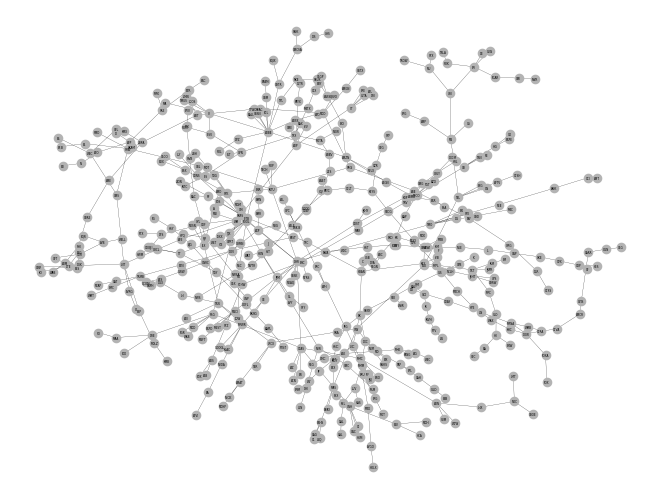

In [24]:
# Visualize graph
pos = nx.spring_layout(min_st)
nx.draw(min_st, pos, with_labels=True, node_color=[[.7, .7, .7]], node_size=35, width=0.15, font_size=2)

In [25]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.independent_set import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [26]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cuda, torch dtype: torch.float32


In [27]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

In [47]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2, alpha = 0.1):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """
    Q_dic = OrderedDict()
    sum_distances = 0
    sum_returns = sum(returns)
    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = nx_G[u][v]["weight"] * (1 - alpha)
    
    Ratio = sum_distances/sum_returns
    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -returns[indexes[u]] * alpha
        
    return Q_dic

# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

In [29]:
corr_matrix2 = np.asmatrix(result)

indexes = {k: v for v, k in enumerate(result.columns)}

In [48]:
# Graph hypers
n = 464
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 70    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 464

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

In [49]:
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(min_st)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(min_st, gen_q_dict_mis(min_st), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

In [33]:
# helper function to convert Q dictionary to torch tensor
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[indexes[x_coord]][indexes[y_coord]] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat

In [36]:
indexes2 = {v: k for k, v in indexes.items()}

In [50]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [51]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 25.866016387939453
Epoch: 1000, Loss: 4.825898170471191
Epoch: 2000, Loss: -3.221437692642212
Epoch: 3000, Loss: -10.316853523254395
Epoch: 4000, Loss: -15.105443000793457
Epoch: 5000, Loss: -17.382614135742188
Epoch: 6000, Loss: -19.019567489624023
Epoch: 7000, Loss: -19.754043579101562
Epoch: 8000, Loss: -20.132946014404297
Stopping early on epoch 8426 (patience: 70)
GNN training (n=464) took 61.664
GNN final continuous loss: -20.17789649963379
GNN best continuous loss: -20.17789649963379


In [52]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, min_st)
gnn_tot_time = time() - gnn_start

print(f'Бројот на акции за креирање на портфолио најдени со GNN е {size_mis}')
print(f'Потребното време за тренирање на моделот: {round(gnn_time, 3)}s')

Calculating violations...
Бројот на акции за креирање на портфолио најдени со GNN е 166
Потребното време за тренирање на моделот: 61.666s


In [54]:
import matplotlib.pyplot as plt

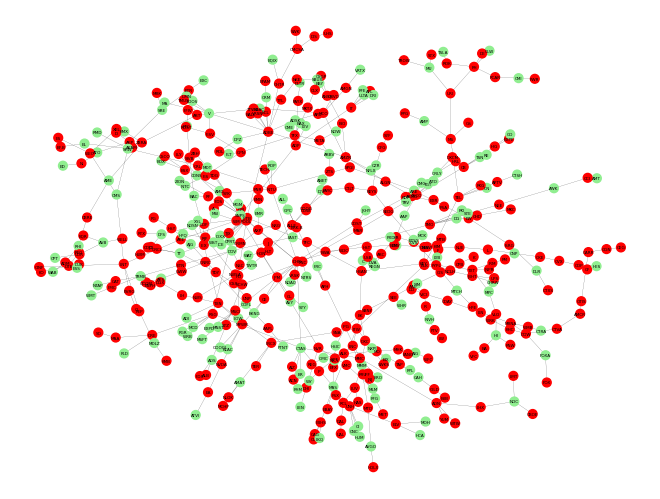

In [55]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['red' if (best_bitstring[indexes[node]]==0) else 'lightgreen' for node in min_st.nodes]
nx.draw(min_st, pos, with_labels=True, node_color=color_map, node_size=40,font_size=3, width=0.1)
plt.savefig('final.png')

In [56]:
final_bit = best_bitstring

In [57]:
indexes_of_final_stocks2 = []
for i in range(0, 464):
    if best_bitstring[i] == 1:
        indexes_of_final_stocks2.append(indexes2[i])

In [58]:
df_gnn1 = neg[[c for c in neg.columns if c in indexes_of_final_stocks2]]

In [396]:
df_gnn2 = neg[[c for c in neg.columns if c in indexes_of_final_stocks2]]

In [97]:
df_gnn1.head()

,AOS,ACN,AES,ALGN,ALL,GOOGL,MO,AMZN,AMD,AIG,...,TYL,USB,VRSK,VMC,WMT,WAT,WST,WY,XEL,XYL
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-03,10.3175,52.95,12.12,23.95,27.75,16.65139,28.56,8.9515,5.48,24.07,...,30.34,27.58,39.36,39.68,60.33,75.94,19.075,19.10,27.34,25.14
2012-01-04,10.4825,52.93,12.03,24.41,27.56,16.72321,28.40,8.8755,5.46,23.92,...,30.36,27.57,38.98,39.30,59.71,74.45,18.895,18.89,27.16,25.97
2012-01-05,10.5025,51.92,12.32,24.19,27.74,16.49123,28.83,8.8805,5.46,23.91,...,31.09,27.98,39.13,39.62,59.42,73.71,18.915,18.78,27.28,25.60
2012-01-06,10.4350,51.83,12.23,23.71,28.02,16.26626,28.72,9.1305,5.43,23.54,...,31.81,27.75,39.37,39.29,59.00,74.15,18.975,19.02,27.20,25.17
2012-01-09,10.4925,51.74,12.47,22.67,28.14,15.57659,28.50,8.9280,5.59,24.00,...,31.56,28.24,39.38,39.50,59.18,74.27,19.015,18.79,27.22,25.27


In [59]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [60]:
def calculate_portfolio_performance(df):
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe(risk_free_rate=0.0045)
    cleaned_weights = ef.clean_weights()
    # ef.save_weights_to_file("weights.csv")  # saves to file
    # print(cleaned_weights)
    returns, volatility, sharpe = ef.portfolio_performance(verbose=True, risk_free_rate=0.0045)
    return returns, volatility, sharpe

In [61]:
calculate_portfolio_performance(df_gnn1)

Expected annual return: 22.3%
Annual volatility: 10.3%
Sharpe Ratio: 2.12


(0.22286876243577974, 0.10282919112217659, 2.1236067312474014)

In [59]:
import random

stock_random = random.sample(list(neg.columns), 166)
df_random = neg[[c for c in neg.columns if c in stock_random]]

In [60]:
calculate_portfolio_performance(df_random)

Expected annual return: 17.1%
Annual volatility: 11.2%
Sharpe Ratio: 1.49


(0.17093607102380193, 0.11154402747891345, 1.4921110057216231)